In [3]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection

# Linear Regression Model

In [5]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

### Train-test split

In [7]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [9]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [13]:
X_train.shape, X_test.shape

((15513, 42), (3879, 42))

### Fitting

In [15]:
LR = LinearRegression()
LR = LR.fit(X_train, y_train)

### Metrics before GridSearch

In [17]:
def compute_metrics(model, x, y, cv=None):
    preds = model.predict(x)
    score = model.score(x, y)

    results = {
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3)
    }

    if cv:
        scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)
        results["cv_score"] = round(scores_cvs.mean() * 100, 2)

    return pd.DataFrame([results])

In [19]:
train_metrics = compute_metrics(LR, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2
0,0.608,0.122,0.349,0.278,0.607


In [21]:
val_metrics = compute_metrics(LR, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2
0,0.599,0.119,0.345,0.275,0.594


### GridSearch

In [23]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__copy_X': [True, False],
    'regressor__positive': [True, False],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='r2')
model_grid = grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Best hyperparameters: {'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__positive': False}
Best R2 score: 0.6048352797393678


### Metrics after GridSearch

In [25]:
best_LR = model_grid.best_estimator_
val_metrics = compute_metrics(best_LR, X_test, y_test, cv=None)
val_metrics

,R2,mse,rmse,mae,adjusted_r2
0,0.599,0.119,0.345,0.275,0.594


# CatBoost Model

In [5]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
import catboost as cb
from sklearn import metrics, model_selection

In [7]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

### Train-test split

In [10]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [12]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

### Fitting

In [19]:
model = cb.CatBoostRegressor(random_seed=42, logging_level='Silent')

model = model.fit(X_train, y_train)

### Metrics before GridSearch

In [24]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [26]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.926,0.023,0.152,0.113,0.926,89.74


In [29]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.898,0.03,0.174,0.128,0.897,84.97


### GridSearch

In [32]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lea

In [44]:
from pprint import pprint
from sklearn.model_selection import GridSearchCV

grid = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 3]
}

grid_search = GridSearchCV(
    estimator=cb.CatBoostRegressor(verbose=0, random_state=42),  # silence CatBoost output
    param_grid=grid,
    refit=True,
    verbose=3,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

model_grid = grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best hyperparameters: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}
Best R2 score: 0.941680448895007


### Metrics after GridSearch

In [47]:
best_CB = grid_search.best_estimator_
val_metrics = compute_metrics(best_CB, X_test, y_test, cv=None)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.951,0.015,0.12,0.081,0.951,86.44


### RandomizedSearchCV

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from pprint import pprint

param_distributions = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 3]
}

random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_distributions=param_distributions,
    n_iter=30,            
    scoring='r2',
    cv=5,
    verbose=3,
    n_jobs=-1,
    refit=True,
    random_state=42
)

model_random = random_search.fit(X_train, y_train)

print("Best hyperparameters:")
pprint(random_search.best_params_)
print("Best R2 score:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters:
{'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best R2 score: 0.9388331580895333


In [54]:
best_CB2 = random_search.best_estimator_
val_metrics2 = compute_metrics(best_CB2,X_test, y_test, cv=None)
val_metrics2

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.946,0.016,0.127,0.086,0.945,86.29


In [62]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import time

space = {
    'iterations': scope.int(hp.quniform('iterations', 100, 1000, 100)),
    'learning_rate' : hp.uniform('learning_rate', 0.03, 1),
    'depth': scope.int(hp.quniform('depth', 0, 10, 1)),
    'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0.2, 3)
}

def objective_catboost(params):
    model = CatBoostRegressor(
        verbose=0,
        random_state=42,
        **params
    )
    score = cross_val_score(model, X_train, y_train, scoring='r2', cv=3).mean()
    return {'loss': 1 - score, 'status': STATUS_OK}

start = time.time()
trials = Trials()

best_params = fmin(
    fn=objective_catboost,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(42),
    trials=trials
)

print("\n✅ Best hyperparameters:", best_params)
print("⏱️ Total tuning time: %.2f minutes" % ((time.time() - start) / 60))

100%|██████████| 30/30 [04:03<00:00,  8.11s/trial, best loss: 0.06450300803683173]

✅ Best hyperparameters: {'depth': 9.0, 'iterations': 600.0, 'l2_leaf_reg': 1.0333526083506885, 'learning_rate': 0.39934084145965404}
⏱️ Total tuning time: 4.05 minutes


In [64]:
best_model3 = CatBoostRegressor(verbose=0, random_state=42, **best_params)
best_model3.fit(X_train, y_train)

In [66]:
metrics_df = compute_metrics(best_model3, X_test, y_test)
metrics_df

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.967,0.01,0.099,0.051,0.967,84.35


# XGB Model

In [61]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
import xgboost as xgb
from sklearn import metrics, model_selection

In [63]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

### Train-test split

In [65]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [67]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [69]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

### Fitting

In [71]:
model = xgb.XGBRegressor()
model = model.fit(X_train, y_train)

### GridSearch

In [93]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [113]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

grid_params = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'objective' : ['reg:squarederror','reg:linear'],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.5, 1],
    'subsample': [0.2, 0.4, 1],
    'max_depth': [1, 2, 6],
    'colsample_bytree': [0.75, 0.8, 0.85]
}

In [115]:
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(), param_grid=grid_params,
    refit=True, verbose=3, cv=5, scoring='r2', n_jobs=-1
)
model_grid = grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Best hyperparameters: {'colsample_bytree': 0.85, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 1}
Best R2 score: 0.9472682951724247


### Metrics before GridSearch

In [83]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [85]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.955,0.014,0.119,0.085,0.955,91.72


In [87]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.92,0.024,0.154,0.109,0.919,85.32


### Metrics after GridSearch

In [117]:
best_XGB = grid_search.best_estimator_
val_metrics = compute_metrics(best_XGB, X_test, y_test, cv=None)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.962,0.011,0.106,0.06,0.962,85.74


### RandomizedSearchCV

In [127]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
import xgboost as xgb

# Define your parameter space
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'objective': ['reg:squarederror', 'reg:linear'],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.5, 1],
    'subsample': [0.2, 0.4, 1],
    'max_depth': [1, 2, 6],
    'colsample_bytree': [0.75, 0.8, 0.85]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(),
    param_distributions=param_distributions,
    n_iter=30,               
    scoring='r2',
    cv=5,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

model_random = random_search.fit(X_train, y_train)

print("Best hyperparameters:")
pprint(random_search.best_params_)
print("Best R2 score:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters:
{'colsample_bytree': 0.8,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 300,
 'objective': 'reg:linear',
 'subsample': 1}
Best R2 score: 0.9398873760512012


In [129]:
best_XGB2 = random_search.best_estimator_
val_metrics2 = compute_metrics(best_XGB2, X_test, y_test, cv=None)
val_metrics2

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\re

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.95,0.015,0.122,0.077,0.95,85.63


### XGB BO

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
import xgboost as xgb
from sklearn import metrics, model_selection

In [3]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

In [5]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [7]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [11]:
model = xgb.XGBRegressor()
model = model.fit(X_train, y_train)

In [13]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [15]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.92,0.024,0.154,0.109,0.919,85.32


## Bayesian Optimization

In [115]:
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 10, 1)),
        'gamma': hp.uniform ('gamma', 0, 5),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.uniform('min_child_weight', 1, 10),
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
        'subsample' : hp.uniform('subsample', 0.5, 1)}

def objective_xgb(params):
    model = XGBRegressor(
        random_state=42,
        verbosity=0,
        **params
    )
    score = cross_val_score(model, X_train, y_train, scoring='r2', cv=3).mean()
    return 1 - score

start = time.time()
best_parameters = fmin(
    fn=objective_xgb,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(42)
)
print("\n✅ Best parameter indexes (from hp.choice):", best_parameters)

100%|██████████| 30/30 [00:37<00:00,  1.26s/trial, best loss: 0.07308661313740183]

✅ Best parameter indexes (from hp.choice): {'colsample_bytree': 0.5072207907227858, 'gamma': 0.0045295286455898694, 'max_depth': 8.0, 'min_child_weight': 7.393000435854846, 'n_estimators': 400.0, 'subsample': 0.7717514426948018}


In [117]:
best_parameters["n_estimators"] = int(best_parameters["n_estimators"])
best_parameters["max_depth"] = int(best_parameters["max_depth"])

In [119]:
best_model = XGBRegressor(random_state=42, verbosity=0, **best_parameters)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5072207907227858, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0045295286455898694, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=7.393000435854846, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [121]:
metrics_df = compute_metrics(best_model, X_test, y_test)
metrics_df

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.955,0.013,0.116,0.074,0.954,83.55


# SVM Model

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.svm import SVR
from sklearn import metrics, model_selection

In [3]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

### Train-test split

In [6]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [8]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [12]:
X_train.shape, X_test.shape

((15513, 42), (3879, 42))

### Fitting

In [15]:
model = SVR()
model = model.fit(X_train, y_train)

In [30]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Metrics before GridSearch

In [18]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [20]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.857,0.044,0.211,0.153,0.857,82.5


In [23]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.832,0.05,0.224,0.163,0.83,78.53


## GridSearch

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.5],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVR(),param_grid)
model_grid = grid_search.fit(X_train,y_train)

print("Best hyperparameters:", str(model_grid.best_params_))
print("Best R2 score:", str(model_grid.best_score_))

Best hyperparameters: {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
Best R2 score: 0.8821199695849178


## Metrics after GridSearch

In [28]:
best_SVM = grid_search.best_estimator_
val_metrics = compute_metrics(best_SVM, X_test, y_test, cv=None)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.914,0.025,0.159,0.114,0.913,71.95


### RandomizedSearchCV

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.1, 0.3, 0.5],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

random_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_distributions,
    n_iter=10,              
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

model_random = random_search.fit(X_train, y_train)

print("Best hyperparameters:", model_random.best_params_)
print("Best R2 score:", model_random.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Best R2 score: 0.8397444984730642


In [37]:
best_SVM2 = model_random.best_estimator_
val_metrics2 = compute_metrics(best_SVM2, X_test, y_test, cv=None)
val_metrics2

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.914,0.025,0.159,0.114,0.913,71.95


In [41]:
best_SVM3 = model_random.best_estimator_
val_metrics3 = compute_metrics(best_SVM3, X_test, y_test, cv=None)
val_metrics3

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.848,0.045,0.213,0.154,0.846,79.21


### SVM BO

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.svm import SVR
from sklearn import metrics, model_selection

In [3]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

In [5]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [7]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [11]:
model = SVR()
model = model.fit(X_train, y_train)

In [12]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [15]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [17]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.832,0.05,0.224,0.163,0.83,78.53


## Bayesian Optimization

In [20]:
from hyperopt import hp, fmin, tpe
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np
import time

In [22]:
param_space = {
    'C': hp.choice('C', [0.1, 1, 10]),
    'gamma': hp.choice('gamma', [0.1, 0.5]),
    'kernel': hp.choice('kernel', ['rbf', 'linear'])
}

def objective_svr(params):
    model = SVR(**params)
    score = cross_val_score(model, X_train, y_train, scoring='r2', cv=3).mean()
    return 1 - score  # Hyperopt minimizes

start = time.time()

best_params_indices = fmin(
    fn=objective_svr,
    space=param_space,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(42)
)

print("\nBest index-based params:", best_params_indices)

100%|██████████| 30/30 [21:20<00:00, 42.67s/trial, best loss: 0.14078411078390352] 

Best index-based params: {'C': 2, 'gamma': 1, 'kernel': 0}


In [24]:
param_choices = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.5],
    'kernel': ['rbf', 'linear']
}

best_params = {key: param_choices[key][best_params_indices[key]] for key in best_params_indices}

print("✅ Best hyperparameters:", best_params)
print("⏱️ Total time: %.2f minutes" % ((time.time() - start) / 60))

✅ Best hyperparameters: {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
⏱️ Total time: 25.75 minutes


In [30]:
best_model = SVR(**best_params)
best_model.fit(X_train, y_train)

SVR(C=10, gamma=0.5)

In [32]:
df_metrics = compute_metrics(best_model, X_test, y_test)
df_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.914,0.025,0.159,0.114,0.913,71.95


In [36]:
param_space2 = {
    'C': hp.uniform ('C', 0.1, 10),
    'gamma': hp.uniform ('gamma', 0.1, 0.5),
}

def objective_svr(params):
    model = SVR(**params)
    score = cross_val_score(model, X_train, y_train, scoring='r2', cv=3).mean()
    return 1 - score  # Hyperopt minimizes

start = time.time()

best_params_indices2 = fmin(
    fn=objective_svr,
    space=param_space2,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(42)
)

print("\nBest index-based params:", best_params_indices2)

100%|██████████| 30/30 [13:17<00:00, 26.59s/trial, best loss: 0.12788993116963665]

Best index-based params: {'C': 4.01961654010362, 'gamma': 0.32113016749736545}


In [39]:
best_model2 = SVR(**best_params_indices2)
best_model2.fit(X_train, y_train)

SVR(C=4.01961654010362, gamma=0.32113016749736545)

In [41]:
df_metrics2 = compute_metrics(best_model2, X_test, y_test)
df_metrics2

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.905,0.028,0.168,0.119,0.904,77.21


In [43]:
import os
os.getcwd()

'C:\\Users\\COMTREE'

# RF model

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, model_selection

In [2]:
df = pd.read_csv("C:/Users/namuu/Downloads/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

In [3]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [4]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [6]:
model = RandomForestRegressor()
model = model.fit(X_train, y_train)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],             
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],             
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18],           
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],                     
    'bootstrap': [True, False]                   
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=30,            
    scoring='r2',
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=42,
    refit=True
)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)
print("Best R2 score:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best hyperparameters: {'n_estimators': 600, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 100, 'bootstrap': True}
Best R2 score: 0.9305874493752623


### Metrics before RandomizedSearch

In [9]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [11]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics 

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.965,0.011,0.103,0.053,0.964,85.98


### Metrics after RandomizedSearch

In [12]:
best_RF2 = random_search.best_estimator_
val_metrics2 = compute_metrics(best_RF2, X_test, y_test, cv=None)
val_metrics2

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.957,0.013,0.113,0.063,0.957,85.59


### RF GridSearch

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, model_selection

In [3]:
df = pd.read_csv("C:/Users/namuu/Downloads/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

In [4]:
df.shape

(19392, 44)

### Train-test split

In [5]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [6]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [8]:
X_train.shape, X_test.shape

((15513, 42), (3879, 42))

### Fitting

In [9]:
model = RandomForestRegressor()
model = model.fit(X_train, y_train)

### GridSearch

In [10]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

grid = {
    'n_estimators': [100, 200, 300, 400, 500],             
    'max_depth': [10, 30, 50, 70, 90, 100],             
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],                      
    'bootstrap': [True, False]                   
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=grid,
    scoring='r2',
    cv=3,
    verbose=3,
    n_jobs=-1,
    refit=True
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Print best results
print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best R2 score: 0.9382826339838782


### Metrics before GridSearch

In [16]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [17]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.994,0.002,0.042,0.021,0.994,94.81


In [18]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics 

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.964,0.011,0.103,0.053,0.964,86.05


### Metrics after GridSearch

In [19]:
best_RF = grid_search.best_estimator_
val_metrics = compute_metrics(best_RF, X_test, y_test, cv=None)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.965,0.01,0.102,0.053,0.965,86.14


### RF BO

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, model_selection

In [3]:
df = pd.read_csv("C:/Users/COMTREE/Documents/bb/uneguimn_final_ver.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehot__floor_Ламинат                              19392 non-null  float64
 1   onehot__floor_Мод                                  19392 non-null  float64
 2   onehot__floor_Паркет                               19392 non-null  float64
 3   onehot__floor_Плита                                19392 non-null  float64
 4   onehot__floor_Цемент                               19392 non-null  float64
 5   onehot__floor_Чулуу                                19392 non-null  float64
 6   onehot__balcony_0                                  19392 non-null  float64
 7   onehot__balcony_1                                  19392 non-null  float64
 8   onehot__balcony_2                                  19392 non-null  float64
 9   onehot

In [5]:
df.shape

(19392, 44)

In [7]:
X = df.drop(['remainder__price', 'remainder__log1p_price'], axis=1)
X.head()

,onehot__floor_Ламинат,onehot__floor_Мод,onehot__floor_Паркет,onehot__floor_Плита,onehot__floor_Цемент,onehot__floor_Чулуу,onehot__balcony_0,onehot__balcony_1,onehot__balcony_2,onehot__balcony_3+,...,scale__built_year,scale__total_floor,scale__m2,scale__located_floor,scale__posted_year,scale__posted_month,scale__numberofrooms,remainder__garage,remainder__construction_progress,remainder__elevator
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.028602,-1.604722,-0.575924,-0.512406,0.022714,0.230289,-0.861763,1,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-0.762560,-0.512406,0.022714,0.230289,0.364720,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.299142,-1.604722,0.053455,-1.360888,0.022714,0.230289,0.364720,1,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.183844,-1.604722,-1.005601,-1.148768,0.022714,0.230289,-0.861763,0,1,0


In [9]:
y = df['remainder__log1p_price']
y.head()

0    4.875197
1    4.875197
2    4.875197
3    5.303305
4    4.564348
Name: remainder__log1p_price, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42)

In [13]:
model = RandomForestRegressor()
model = model.fit(X_train, y_train)

In [15]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [17]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics 

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.964,0.011,0.103,0.054,0.964,86.09


In [25]:
from hyperopt import hp, fmin, tpe
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import time

space_rf = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [10, 30, 50, 70, 90, 100]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]), 
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'criterion': hp.choice('criterion', ['squared_error', 'absolute_error'])
}

def objective_rf(params):
    model = RandomForestRegressor(random_state=42, **params)
    score = cross_val_score(model, X_train, y_train, scoring='r2', cv=3).mean()
    return 1 - score

start = time.time()
best_params = fmin(
    fn=objective_rf,
    space=space_rf,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(42)
)
print("\nBest hyperparameters:", best_params)
print("Time taken: %.2f minutes" % ((time.time() - start)/60))

100%|██████████| 30/30 [4:17:48<00:00, 515.61s/trial, best loss: 0.06858285371309547]   

Best hyperparameters: {'bootstrap': 1, 'criterion': 1, 'max_depth': 4, 'max_features': 0, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 1}
Time taken: 257.81 minutes


In [39]:
n_estimators_list = [100, 200, 300, 400, 500]
max_depth_list = [10, 30, 50, 70, 90, 100]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list = [1, 2, 4]
max_features_list = ['sqrt', 'log2', None]
bootstrap_list = [True, False]
criterion_list = ['squared_error', 'absolute_error']

converted_params = {
    'n_estimators': n_estimators_list[best_params['n_estimators']],       # 1 → 200
    'max_depth': max_depth_list[best_params['max_depth']],                # 4 → 90
    'min_samples_split': min_samples_split_list[best_params['min_samples_split']],  # 0 → 2
    'min_samples_leaf': min_samples_leaf_list[best_params['min_samples_leaf']],    # 0 → 1
    'max_features': max_features_list[best_params['max_features']],      # 0 → 'sqrt'
    'bootstrap': bootstrap_list[best_params['bootstrap']],               # 1 → False
    'criterion': criterion_list[best_params['criterion']]                # 1 → 'absolute_error'
}

print("✅ Converted best hyperparameters:")
print(converted_params)

✅ Converted best hyperparameters:
{'n_estimators': 200, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'absolute_error'}


In [41]:
best_model = RandomForestRegressor(random_state=42, **converted_params)
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=90,
                      max_features='sqrt', n_estimators=200, random_state=42)

In [43]:
RF_metrics = compute_metrics(best_model, X_test, y_test)
RF_metrics 

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.971,0.009,0.093,0.028,0.971,83.91


In [45]:
# change only criterion
params_squared_error = converted_params.copy()
params_squared_error['criterion'] = 'squared_error'

rf_squared_error = RandomForestRegressor(random_state=42, **params_squared_error)
rf_squared_error.fit(X_train, y_train)

rf_metrics_squared = compute_metrics(rf_squared_error, X_test, y_test)
rf_metrics_squared

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.973,0.008,0.09,0.028,0.972,83.88


In [47]:
model = rf_squared_error 

variables = abs(model.feature_importances_)
coef_df = pd.DataFrame({
    "Variable": df.drop(['remainder__price', 'remainder__log1p_price'], axis=1).columns,
    "Value": variables,
})

n = 10
sorted_df = (
    coef_df.sort_values(by="Value", ascending=False)
           .head(n)
           .sort_values(by="Value")
)

sorted_df

,Variable,Value
41,remainder__elevator,0.011407
29,onehot__location_ Хан-Уул,0.014829
39,remainder__garage,0.018746
27,onehot__location_ Сонгинохайрхан,0.022947
35,scale__located_floor,0.046515
32,scale__built_year,0.049495
33,scale__total_floor,0.075317
31,scale__numberofwindows,0.111417
38,scale__numberofrooms,0.175858
34,scale__m2,0.372531


In [53]:
sorted_df["Variable"] = sorted_df["Variable"].str.replace("remainder__elevator", "elevator")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("onehot__location_ Хан-Уул", "location_HanUul_district")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("remainder__garage", "garage")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("onehot__location_ Сонгинохайрхан", "location_SHD_district")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("scale__located_floor", "located_floor")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("scale__built_year", "built_year")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("scale__total_floor", "total_floor")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("scale__numberofwindows", "numberofwindows")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("scale__numberofrooms", "numberofrooms")
sorted_df["Variable"] = sorted_df["Variable"].str.replace("scale__m2", "size_m2")

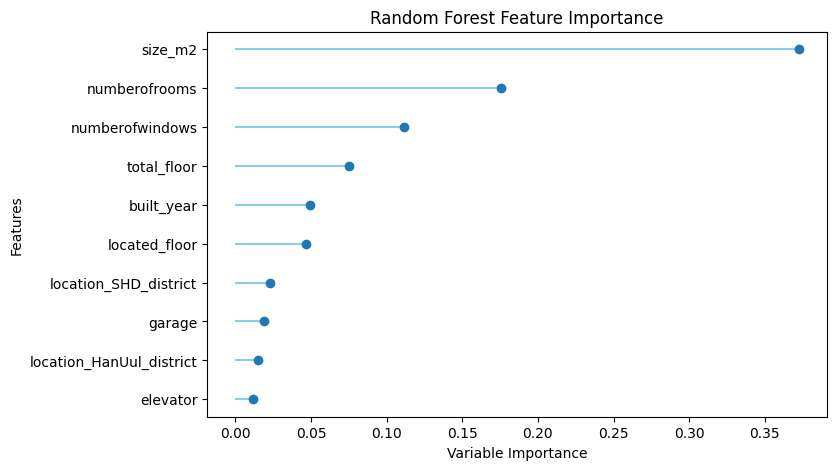

In [57]:
my_range = range(1, len(sorted_df.index) + 1)
plt.figure(figsize=(8, 5 * (n // 10)))
plt.hlines(
    y=my_range,
    xmin=0,
    xmax=sorted_df["Value"],
    color="skyblue",
)
plt.plot(sorted_df["Value"], my_range, "o")
plt.yticks(my_range, sorted_df["Variable"])
plt.title("Random Forest Feature Importance")
plt.xlabel("Variable Importance")
plt.ylabel("Features")
plt.show()